We start by defining a processor for the **HWW** signal 

In [1]:
import numpy as np
import awkward as ak
import hist as hist2
from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch")


def getParticles(genparticles,lowid=22,highid=25,flags=['fromHardProcess', 'isLastCopy']):
    """
    returns the particle objects that satisfy a low id, 
    high id condition and have certain flags
    """
    absid = abs(genparticles.pdgId)
    return genparticles[
        ((absid >= lowid) & (absid <= highid))
        & genparticles.hasFlags(flags)
    ]

def match_HWWlepqq(genparticles,candidatefj):
    """
    return the number of matched objects (hWW*),daughters, 
    and gen flavor (enuqq, munuqq, taunuqq) 
    """
    higgs = getParticles(genparticles,25)
    is_hWW = ak.all(abs(higgs.children.pdgId)==24,axis=2)

    higgs = higgs[is_hWW]
    higgs_wstar = higgs.children[ak.argmin(higgs.children.mass,axis=2,keepdims=True)]
    higgs_w = higgs.children[ak.argmax(higgs.children.mass,axis=2,keepdims=True)]
    
    prompt_electron = getParticles(genparticles,11,11,['isPrompt','isLastCopy'])
    prompt_muon = getParticles(genparticles,13,13,['isPrompt', 'isLastCopy'])
    prompt_tau = getParticles(genparticles,15,15,['isPrompt', 'isLastCopy'])
    prompt_q = getParticles(genparticles,0,5,['fromHardProcess', 'isLastCopy'])
    prompt_q = prompt_q[abs(prompt_q.distinctParent.pdgId) == 24]
    
    dr_fj_quarks = candidatefj.delta_r(prompt_q)
    dr_fj_electrons = candidatefj.delta_r(prompt_electron)
    dr_fj_muons = candidatefj.delta_r(prompt_muon)
    dr_fj_taus = candidatefj.delta_r(prompt_tau)
    dr_daughters = ak.concatenate([dr_fj_quarks,dr_fj_electrons,dr_fj_muons,dr_fj_taus],axis=1)
    hWWlepqq_nprongs = ak.sum(dr_daughters<0.8,axis=1)
    
    n_electrons = ak.sum(prompt_electron.pt>0,axis=1)
    n_muons = ak.sum(prompt_muon.pt>0,axis=1)
    n_taus = ak.sum(prompt_tau.pt>0,axis=1)
    n_quarks = ak.sum(prompt_q.pt>0,axis=1)

    # 4(elenuqq),6(munuqq),8(taunuqq)
    hWWlepqq_flavor = (n_quarks==2)*1 + (n_electrons==1)*3 + (n_muons==1)*5 + (n_taus==1)*7
    
    matchedH = candidatefj.nearest(higgs, axis=1, threshold=0.8)
    matchedW = candidatefj.nearest(higgs_w, axis=1, threshold=0.8)
    matchedWstar = candidatefj.nearest(higgs_wstar, axis=1, threshold=0.8) 

    # 1 (H only), 4(W), 6(W star), 9(H, W and Wstar)
    hWWlepqq_matched = (ak.sum(matchedH.pt>0,axis=1)==1)*1 + (ak.sum(ak.flatten(matchedW.pt>0,axis=2),axis=1)==1)*3 + (ak.sum(ak.flatten(matchedWstar.pt>0,axis=2),axis=1)==1)*5
    
    
    return hWWlepqq_flavor,hWWlepqq_matched,hWWlepqq_nprongs

class HwwSignalProcessor(processor.ProcessorABC):
    def __init__(self,jet_arbitration='pt'):
        self._jet_arbitration = jet_arbitration
        
        # output
        self.make_output = lambda: {
            'sumw': 0.,
            'signal_kin': hist2.Hist(
                hist2.axis.IntCategory([0, 2, 4, 6, 8], name='genflavor', label='gen flavor'),
                hist2.axis.IntCategory([0, 1, 4, 6, 9], name='genHflavor', label='higgs matching'),
                hist2.axis.Regular(100, 200, 1200, name='pt', label=r'Jet $p_T$'),
                hist2.axis.IntCategory([0, 1, 2, 3, 4], name='nprongs', label='Jet n prongs'),
                hist2.storage.Weight(),
            ),
            "lep_kin": hist2.Hist(
                hist2.axis.StrCategory(["hadmu_signal", "hadel_signal"], name="region", label="Region"),
                hist2.axis.Regular(25, 0, 1, name="lepminiIso", label="lep miniIso"),
                hist2.axis.Regular(25, 0, 1, name="leprelIso", label="lep Rel Iso"),
                hist2.axis.Regular(40, 10, 800, name='lep_pt', label=r'lep $p_T$ [GeV]'),
                hist2.storage.Weight(),
            ),
        }
        
    def process(self, events):
        dataset = events.metadata['dataset']
        selection = PackedSelection()
        weights = Weights(len(events), storeIndividual=True)
        weights.add('genweight', events.genWeight)
        
        output = self.make_output()
        output['sumw'] = ak.sum(events.genWeight)
            
        # leptons
        goodmuon = (
            (events.Muon.pt > 25)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.mediumId
        )
        nmuons = ak.sum(goodmuon, axis=1)
        lowptmuon = (
            (events.Muon.pt > 10)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.looseId
        )
        nlowptmuons = ak.sum(lowptmuon, axis=1)
            
        goodelectron = (
            (events.Electron.pt > 25)
            & (abs(events.Electron.eta) < 2.5)
            & (events.Electron.mvaFall17V2noIso_WP80)
        )
        nelectrons = ak.sum(goodelectron, axis=1)
        lowptelectron = (
            (events.Electron.pt > 10)
            & (abs(events.Electron.eta) < 2.5)
            & (events.Electron.cutBased >= events.Electron.LOOSE)
        )
        nlowptelectrons = ak.sum(lowptelectron, axis=1)
        
        goodtau = (
            (events.Tau.pt > 20)
            & (abs(events.Tau.eta) < 2.3)
            & (events.Tau.idAntiEle >= 8)
            & (events.Tau.idAntiMu >= 1)
        )
        ntaus = ak.sum(goodtau, axis=1)

        # concatenate leptons and select leading one
        goodleptons = ak.concatenate([events.Muon[goodmuon], events.Electron[goodelectron]], axis=1)
        candidatelep = ak.firsts(goodleptons[ak.argsort(goodleptons.pt)])
        candidatelep_p4 = ak.zip(
            {
                "pt": candidatelep.pt,
                "eta": candidatelep.eta,
                "phi": candidatelep.phi,
                "mass": candidatelep.mass,
                "charge": candidatelep.charge,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        # lepton isolation
        lep_miniIso = candidatelep.miniPFRelIso_all
        lep_relIso = candidatelep.pfRelIso03_all
        
        # missing transverse energy
        met = events.MET
        
        # jets
        fatjets = events.FatJet
        candidatefj = fatjets[
            (fatjets.pt > 200)
        ]

        dphi_met_fj = abs(candidatefj.delta_phi(met))
        dr_lep_fj = candidatefj.delta_r(candidatelep_p4)
    
        if self._jet_arbitration == 'pt':
            candidatefj = ak.firsts(candidatefj)
        elif self._jet_arbitration == 'met':
            candidatefj = ak.firsts(candidatefj[ak.argmin(dphi_met_fj,axis=1,keepdims=True)])
        elif self._jet_arbitration == 'lep':
            candidatefj = ak.firsts(candidatefj[ak.argmin(dr_lep_fj,axis=1,keepdims=True)])
        else:
            raise RuntimeError("Unknown candidate jet arbitration")
    
        # match HWWlepqq 
        hWWlepqq_flavor,hWWlepqq_matched,hWWlepqq_nprongs = match_HWWlepqq(events.GenPart,candidatefj)
        
        
        # selections
        
        # select only leptons inside the jet
        dr_lep_jet_cut = candidatefj.delta_r(candidatelep_p4) < 0.8
        dr_lep_jet_cut = ak.fill_none(dr_lep_jet_cut, False)
        selection.add("dr_lep_jet", dr_lep_jet_cut)
        
        # select events with only electrons or muons
        selection.add('onemuon', (nmuons == 1) & (nlowptmuons <= 1) & (nelectrons == 0) & (nlowptelectrons == 0) & (ntaus == 0))
        selection.add('oneelectron', (nelectrons == 1) & (nlowptelectrons <= 1) & (nmuons == 0) & (nlowptmuons == 0) & (ntaus == 0))
            
        regions = {
            "hadmu_signal": ["onemuon", "dr_lep_jet"],
            "hadel_signal": ["oneelectron", "dr_lep_jet"]
        }
        
        # function to normalize arrays after a cut or selection
        def normalize(val, cut=None):
            if cut is None:
                ar = ak.to_numpy(ak.fill_none(val, np.nan))
                return ar
            else:
                ar = ak.to_numpy(ak.fill_none(val[cut], np.nan))
                return ar
    
        # lepton kin
        def fill(region):
            selections = regions[region]
            cut = selection.all(*selections)

            output['lep_kin'].fill(
                region=region,
                lepminiIso=normalize(lep_miniIso,cut),
                leprelIso=normalize(lep_relIso,cut),
                lep_pt = normalize(candidatelep.pt,cut),
                weight=weights.weight()[cut],
            )
            
        for region in regions:
            fill(region)
            
        # signal kin
        output['signal_kin'].fill(
            genflavor=normalize(hWWlepqq_flavor,dr_lep_jet_cut),
            genHflavor=normalize(hWWlepqq_matched,dr_lep_jet_cut),
            pt = normalize(candidatefj.pt,dr_lep_jet_cut),
            nprongs = normalize(hWWlepqq_nprongs,dr_lep_jet_cut),
            weight=weights.weight()[dr_lep_jet_cut],
        )
        
        return {dataset: output}
            
    def postprocess(self, accumulator):
        return accumulator

Now, we define a similar a processor for the **QCD**/$t\bar{t}$ backgrounds 

In [2]:
class BackgroundProcessor(processor.ProcessorABC):
    def __init__(self,jet_arbitration='pt'):
        self._jet_arbitration = jet_arbitration
        
        # define an output
        self.make_output = lambda: {
            'sumw': 0.,
            "lep_kin": hist2.Hist(
                hist2.axis.StrCategory(["hadmu_signal", "hadel_signal"], name="region", label="Region"),
                hist2.axis.Regular(25, 0, 1, name="lepminiIso", label="lep miniIso"),
                hist2.axis.Regular(25, 0, 1, name="leprelIso", label="lep Rel Iso"),
                hist2.axis.Regular(40, 10, 800, name='lep_pt', label=r'lep $p_T$ [GeV]'),
                hist2.storage.Weight(),
            ),
        }
        
    def process(self, events):
        dataset = events.metadata['dataset']
        selection = PackedSelection()
        weights = Weights(len(events), storeIndividual=True)
        weights.add('genweight', events.genWeight)
        
        output = self.make_output()
        output['sumw'] = ak.sum(events.genWeight)
            
        # leptons
        goodmuon = (
            (events.Muon.pt > 25)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.mediumId
        )
        nmuons = ak.sum(goodmuon, axis=1)
        lowptmuon = (
            (events.Muon.pt > 10)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.looseId
        )
        nlowptmuons = ak.sum(lowptmuon, axis=1)
            
        goodelectron = (
            (events.Electron.pt > 25)
            & (abs(events.Electron.eta) < 2.5)
            & (events.Electron.mvaFall17V2noIso_WP80)
        )
        nelectrons = ak.sum(goodelectron, axis=1)
        lowptelectron = (
            (events.Electron.pt > 10)
            & (abs(events.Electron.eta) < 2.5)
            & (events.Electron.cutBased >= events.Electron.LOOSE)
        )
        nlowptelectrons = ak.sum(lowptelectron, axis=1)
        
        goodtau = (
            (events.Tau.pt > 20)
            & (abs(events.Tau.eta) < 2.3)
            & (events.Tau.idAntiEle >= 8)
            & (events.Tau.idAntiMu >= 1)
        )
        ntaus = ak.sum(goodtau, axis=1)
        
        
        # concatenate leptons and select leading one
        goodleptons = ak.concatenate([events.Muon[goodmuon], events.Electron[goodelectron]], axis=1)
        candidatelep = ak.firsts(goodleptons[ak.argsort(goodleptons.pt)])
        candidatelep_p4 = ak.zip(
            {
                "pt": candidatelep.pt,
                "eta": candidatelep.eta,
                "phi": candidatelep.phi,
                "mass": candidatelep.mass,
                "charge": candidatelep.charge,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
        # lepton isolation
        lep_miniIso = candidatelep.miniPFRelIso_all
        lep_relIso = candidatelep.pfRelIso03_all
        
        
        # met
        met = events.MET
        
        # jets
        fatjets = events.FatJet
        candidatefj = fatjets[
            (fatjets.pt > 200)
        ]

        dphi_met_fj = abs(candidatefj.delta_phi(met))
        dr_lep_fj = candidatefj.delta_r(candidatelep_p4)
    
        if self._jet_arbitration == 'pt':
            candidatefj = ak.firsts(candidatefj)
        elif self._jet_arbitration == 'met':
            candidatefj = ak.firsts(candidatefj[ak.argmin(dphi_met_fj,axis=1,keepdims=True)])
        elif self._jet_arbitration == 'lep':
            candidatefj = ak.firsts(candidatefj[ak.argmin(dr_lep_fj,axis=1,keepdims=True)])
        else:
            raise RuntimeError("Unknown candidate jet arbitration")
    
            
        # select events with only electrons or muons
        selection.add('onemuon', (nmuons == 1) & (nlowptmuons <= 1) & (nelectrons == 0) & (nlowptelectrons == 0) & (ntaus == 0))
        selection.add('oneelectron', (nelectrons == 1) & (nlowptelectrons <= 1) & (nmuons == 0) & (nlowptmuons == 0) & (ntaus == 0))
            
        # select only leptons inside the jet
        dr_lep_jet_cut = candidatefj.delta_r(candidatelep_p4) < 0.8
        dr_lep_jet_cut = ak.fill_none(dr_lep_jet_cut, False)
        selection.add("dr_lep_jet", dr_lep_jet_cut)
        
        regions = {
            "hadmu_signal": ["onemuon", "dr_lep_jet"],
            "hadel_signal": ["oneelectron", "dr_lep_jet"]
        }
        
        # function to normalize arrays after a cut or selection
        def normalize(val, cut=None):
            if cut is None:
                ar = ak.to_numpy(ak.fill_none(val, np.nan))
                return ar
            else:
                ar = ak.to_numpy(ak.fill_none(val[cut], np.nan))
                return ar
    
        def fill(region):
            selections = regions[region]
            cut = selection.all(*selections)

            output['lep_kin'].fill(
                region=region,
                lepminiIso=normalize(lep_miniIso,cut),
                leprelIso=normalize(lep_relIso,cut),
                lep_pt = normalize(candidatelep.pt,cut),
                weight=weights.weight()[cut],
            )
            
        for region in regions:
            fill(region)

        return {dataset: output}
            
    def postprocess(self, accumulator):
        return accumulator

Here we set the dask client and run the processor for signal and backgrounds using UL data

In [3]:
from dask.distributed import Client

client = Client("tls://daniel-2eocampo-2ehenao-40cern-2ech.dask.coffea.casa:8786")
client

<Client: 'tls://192.168.134.219:8786' processes=1 threads=2, memory=7.00 GiB>

In [4]:
fileset = {
    'HWW': ["root://xcache/" + file for file in np.loadtxt("data/hwwdata.txt", dtype=str)]
}

hwwout = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=HwwSignalProcessor(jet_arbitration="met"),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
        maxchunks=30,
    )

In [5]:
fileset = {
    "tt": ["root://xcache/" + file for file in np.loadtxt("data/ttsemileptonicdata.txt", dtype=str)][:50]
}

ttout = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=BackgroundProcessor(jet_arbitration="met"),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
    maxchunks=30,
)

In [6]:
fileset = {
    "qcd": ["root://xcache/" + file for file in np.loadtxt("data/qcdht300to500data.txt", dtype=str)][:12] +
    ["root://xcache/" + file for file in np.loadtxt("data/qcdht500to700data.txt", dtype=str)][:12] +
    ["root://xcache/" + file for file in np.loadtxt("data/qcdht700to1000data.txt", dtype=str)][:12] +
    ["root://xcache/" + file for file in np.loadtxt("data/qcdht1000to1500data.txt", dtype=str)][:12] +
    ["root://xcache/" + file for file in np.loadtxt("data/qcdht1500to2000data.txt", dtype=str)][:12] + 
    ["root://xcache/" + file for file in np.loadtxt("data/qcdht2000toInfdata.txt", dtype=str)]
}

qcdout = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=BackgroundProcessor(jet_arbitration="met"),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
    maxchunks=30,
)

First, we plot the results for the jets, matched jets, jet flavor and daughters

In [7]:
import matplotlib.pyplot as plt
from matplotlib import colors
import mplhep as hep
import scipy
hep.style.use(hep.style.CMS)


hsig = hwwout["HWW"]["signal_kin"]
hlep = hwwout["HWW"]["lep_kin"]
htt = ttout["tt"]["lep_kin"]
hqcd = qcdout["qcd"]["lep_kin"]

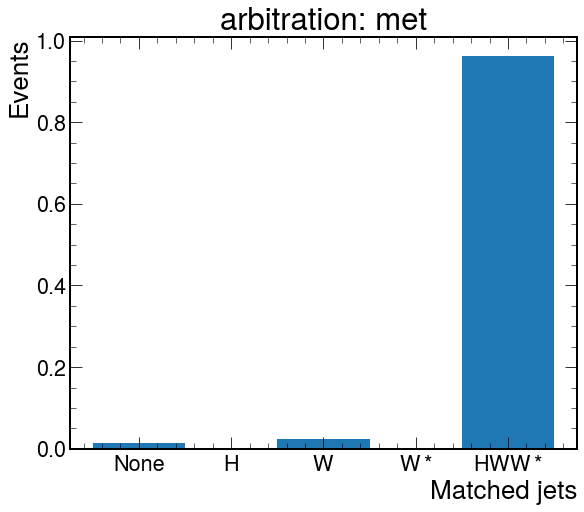

In [8]:
# hWWlepqq_matched
gen_Hflavor = hsig[{"genflavor": sum, "pt": sum, "nprongs":sum}]
match = ["None",r"$H$",r"$W$",r"$W*$",r"$HWW*$"]

fig, ax = plt.subplots(
    figsize=(8,7), 
    constrained_layout=True
)
gen_Hflavor.plot1d(
    ax=ax,
    histtype="fill",
    density=True
)
ax.set(
    title="arbitration: met",
    ylabel="Events",
    xlabel="Matched jets",
    xticklabels=match
);

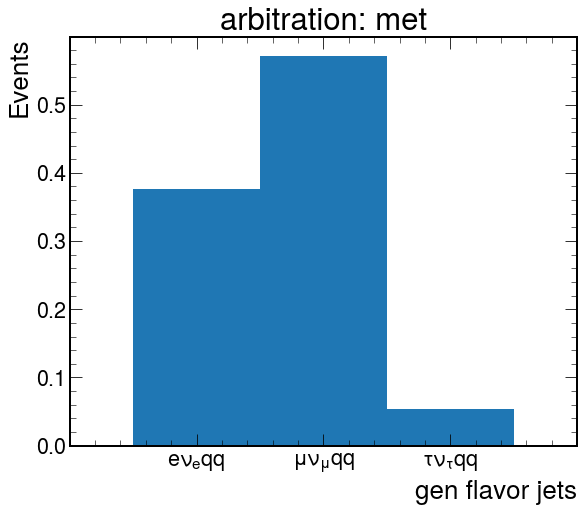

In [9]:
# hWWlepqq_flavor
gen_flavor = hsig[{"genHflavor": sum, "pt": sum, "nprongs":sum}]

fig, ax = plt.subplots(
    figsize=(8,7),
    constrained_layout=True
)
gen_flavor.plot1d(
    ax=ax,
    density=True,
    histtype="fill",
)
ax.set(
    title="arbitration: met",
    ylabel="Events",
    xlabel="gen flavor jets",
    xlim=(1.5,5.5),
    xticklabels=["","",r"$e\nu_e qq$", r"$\mu\nu_{\mu}qq$", r"$\tau\nu_{\tau}qq$"]
);

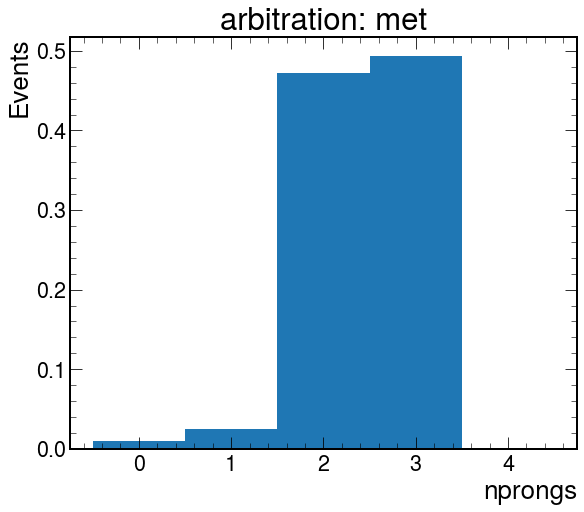

In [10]:
# number of daus
nprongs = hsig[{"genHflavor":sum, "pt": sum, "genflavor": sum}]

fig, ax = plt.subplots(
    figsize=(8,7),
    constrained_layout=True
)
nprongs.plot1d(
    ax=ax,
    histtype="fill",
    density=True
)
ax.set(
    title="arbitration: met",
    ylabel="Events",
    xlabel="nprongs"
);

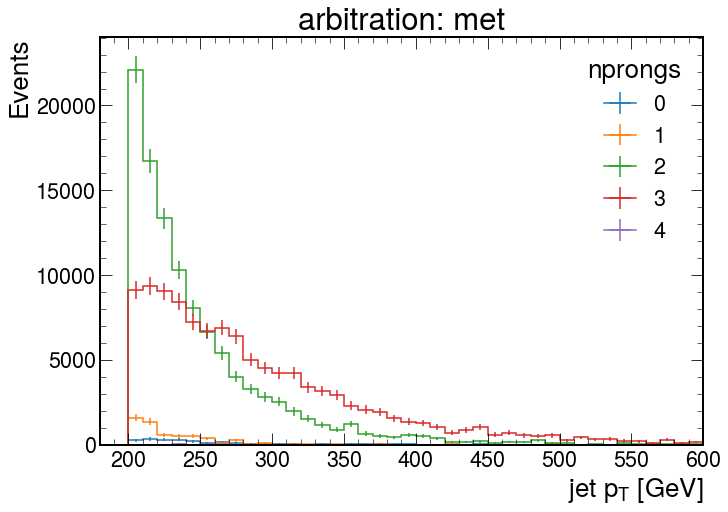

In [11]:
# hWWlepqq_nprongs and jet pt
h = hsig[{"genHflavor": sum, "genflavor":sum}]

fig, ax = plt.subplots(
    figsize=(10,7),
    constrained_layout=True
)
h.plot1d(ax=ax)
    
ax.set(
    title="arbitration: met",
    ylabel="Events",
    xlim=(180,600),
    xlabel="jet $p_T$ [GeV]"
)
ax.legend(
    title="nprongs"
);

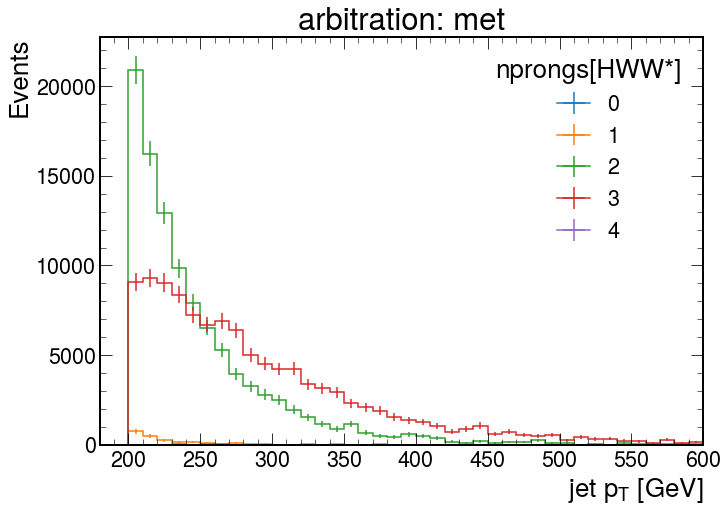

In [12]:
# hWWlepqq_nprongs and jet pt with HWW match
h = hsig[{"genflavor":sum}]

fig, ax = plt.subplots(
    figsize=(10,7),
    constrained_layout=True
)

h[-1,:,:].plot1d(ax=ax)

ax.set(
    title="arbitration: met",
    xlim=(180,600),
    xlabel="jet $p_T$ [GeV]",
    ylabel="Events"
)
ax.legend(
    title="nprongs[HWW*]"
);

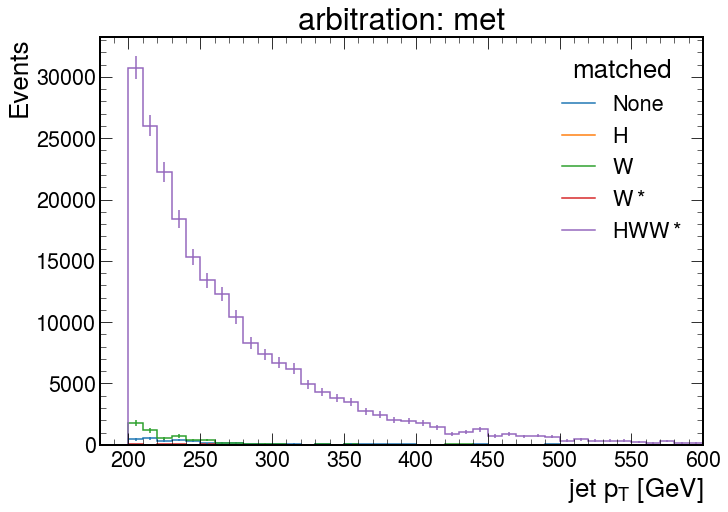

In [13]:
# hWWlepqq_matched and jet pt
h = hsig[{"nprongs":sum, "genflavor":sum}]

fig, ax = plt.subplots(
    figsize=(10,7),
    constrained_layout=True
)
for i in range(5): 
        h[i,:].plot1d(ax=ax)
        
ax.set(
    title="arbitration: met",
    ylabel="Events",
    xlim=(180,600),
    xlabel="jet $p_T$ [GeV]"
)
ax.legend(
    match, 
    title="matched"
);

Now, we let's see the results for the leptons

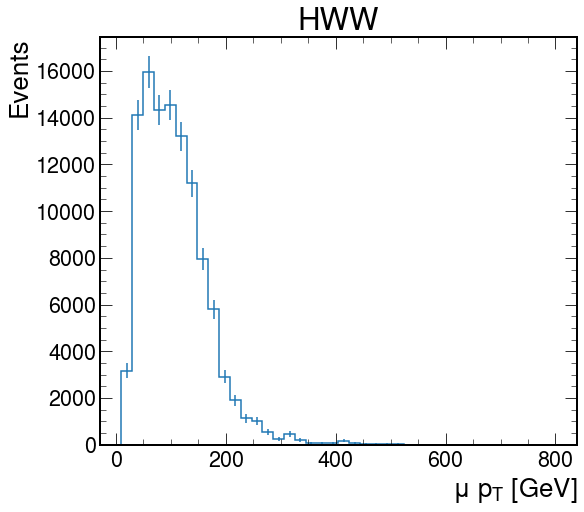

In [15]:
# muon pT
fig, ax = plt.subplots(
    figsize=(8,7),
    constrained_layout=True,
)

hlep[{'leprelIso':sum,"region":"hadmu_signal", "lepminiIso":sum}].plot1d(ax=ax)

ax.set(
    title="HWW",
    xlabel="$\mu$ $p_T$ [GeV]",
    ylabel="Events"
)
fig.savefig("hww_mu_pt.png")

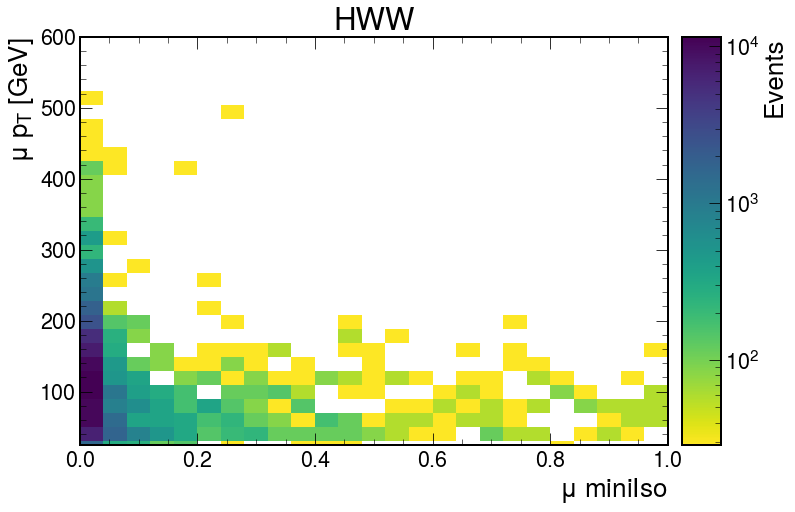

In [16]:
# muon pt vs mini isolation
fig, ax = plt.subplots(
    figsize=(10,7),
    constrained_layout=True,
)

hist = hlep[{'leprelIso':sum,"region":"hadmu_signal"}].plot2d(
    ax=ax,
    norm=colors.LogNorm(),
    cmap="viridis_r",
)

ax.set(
    title="HWW",
    xlabel="$\mu$ miniIso",
    ylabel="$\mu$ $p_T$ [GeV]",
    ylim=(25,600)
)
hist.cbar.set_label("Events")
plt.gcf().savefig("hww_mu_ptvsminiIso.png")

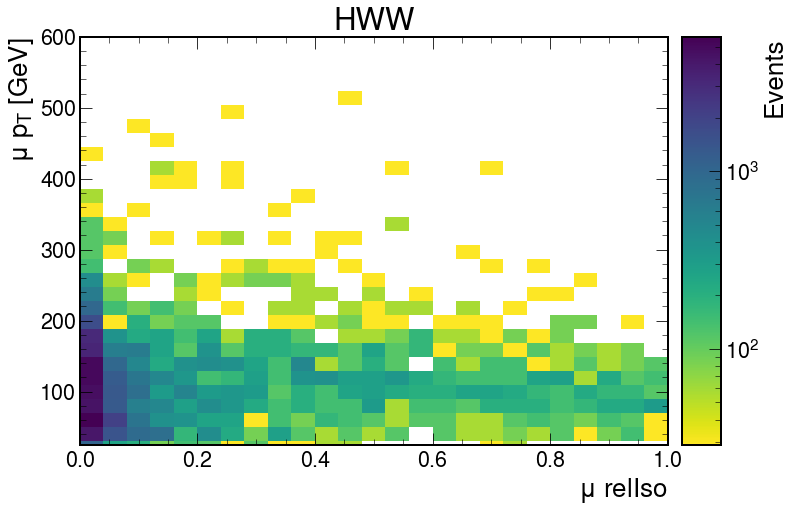

In [17]:
# muon pt vs relative isolation
fig, ax = plt.subplots(
    figsize=(10,7),
    constrained_layout=True,
)

hist= hlep[{'lepminiIso':sum,"region":"hadmu_signal"}].plot2d(
    ax=ax,
    norm=colors.LogNorm(),
    cmap="viridis_r",
)
ax.set(
    title="HWW",
    xlabel="$\mu$ relIso",
    ylabel="$\mu$ $p_T$ [GeV]",
    ylim=(25, 600)
)
hist.cbar.set_label("Events")
fig.savefig("hww_mu_ptvsrelIso.png")

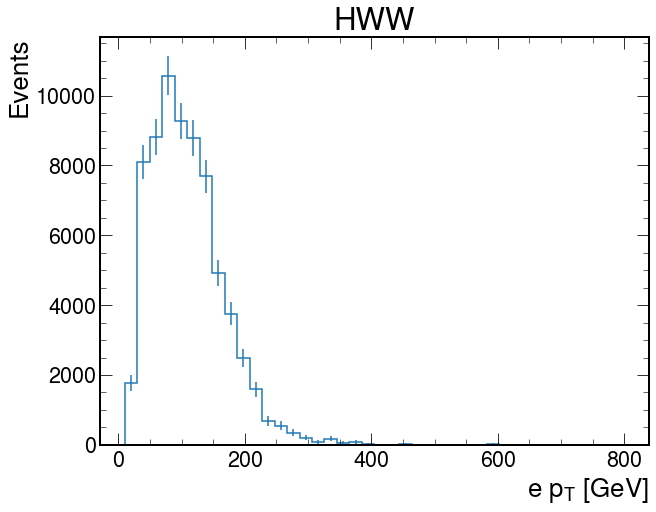

In [18]:
# electron pT
fig, ax = plt.subplots(
    figsize=(9,7),
    constrained_layout=True,
)

hlep[{'leprelIso':sum,"region":"hadel_signal", "lepminiIso":sum}].plot1d(ax=ax)
ax.set(
    title="HWW",
    xlabel="$e$ $p_T$ [GeV]",
    ylabel="Events"
)
fig.savefig("hww_el_pt.png")

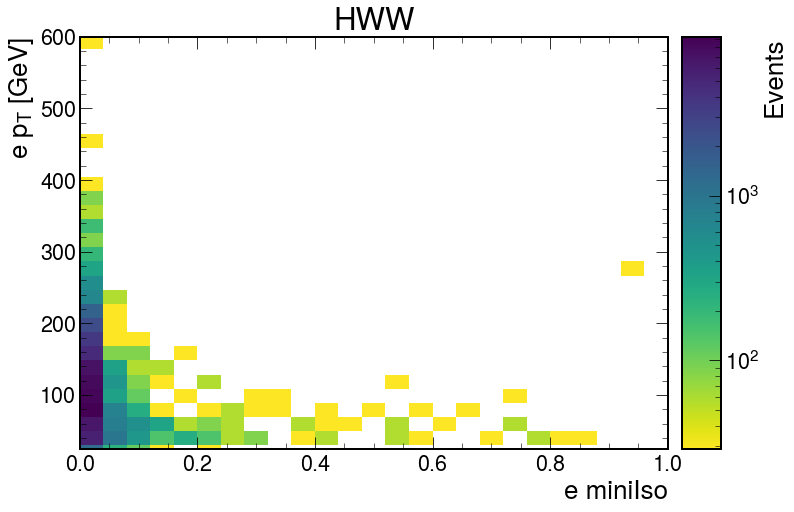

In [19]:
# electron pT vs mini isolation
fig, ax = plt.subplots(
    figsize=(10,7),
    constrained_layout=True,
)

hist = hlep[{'leprelIso':sum,"region":"hadel_signal"}].plot2d(
    ax=ax,
    norm=colors.LogNorm(),
    cmap="viridis_r",
)
ax.set(
    title="HWW",
    xlabel="e miniIso",
    ylabel="$e$ $p_T$ [GeV]",
    ylim=(25, 600)
)
hist.cbar.set_label("Events")
fig.savefig("hww_el_ptvsminiIso.png")

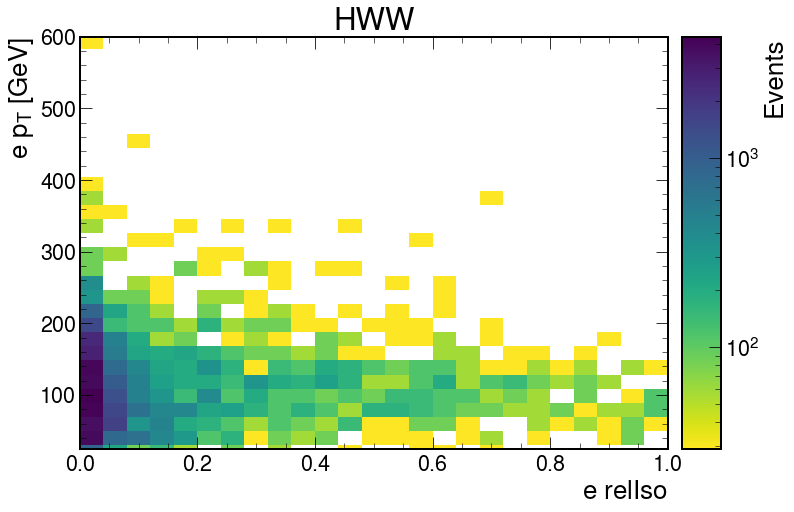

In [20]:
# electron pT vs relative isolation
fig, ax = plt.subplots(
    figsize=(10,7),
    constrained_layout=True,
)

hist = hlep[{'lepminiIso':sum,"region":"hadel_signal"}].plot2d(
    ax=ax,
    norm=colors.LogNorm(),
    cmap="viridis_r",
)
ax.set(
    title="HWW",
    xlabel="$e$ relIso",
    ylabel="$e$ $p_T$ [GeV]",
    ylim=(25, 600)
)
hist.cbar.set_label("Events")
fig.savefig("hww_el_ptvsrelIso.png")

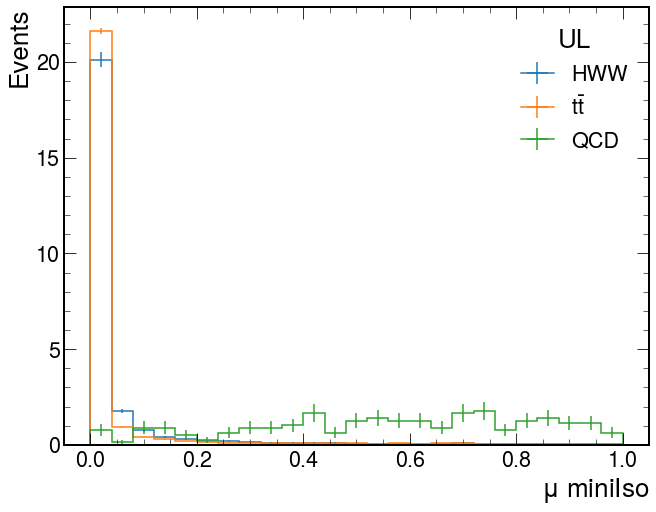

In [21]:
# muon mini isolation
fig, ax = plt.subplots(
    figsize=(9,7), 
    constrained_layout=True
)

hlep[{'leprelIso':sum, "lep_pt":sum, "region":"hadmu_signal"}].plot1d(
    ax=ax,
    label="HWW",
    density=True,
)
htt[{'leprelIso':sum, "lep_pt":sum, "region":"hadmu_signal"}].plot1d(
    ax=ax,
    label=r"$t \bar{t}$",
    density=True,
)
hqcd[{'leprelIso':sum, "lep_pt":sum, "region":"hadmu_signal"}].plot1d(
    ax=ax,
    label="QCD",
    density=True,
)
ax.legend(
    title="UL",
)

ax.set(
    xlabel="$\mu$ miniIso",
    ylabel="Events",
)
fig.savefig("hww_mu_miniIso.png");

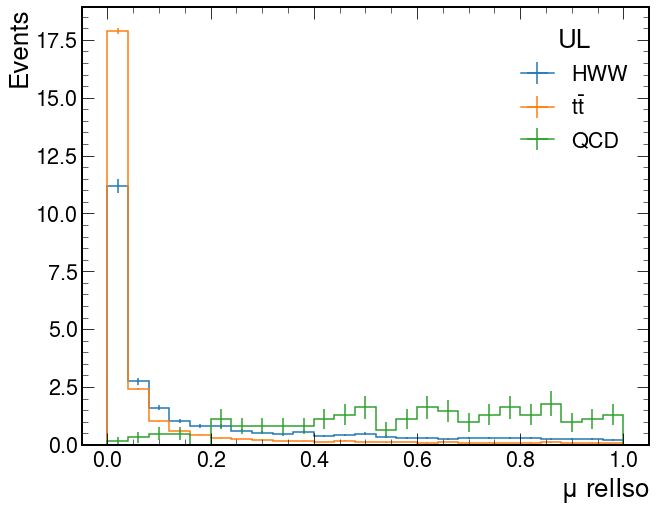

In [22]:
# muon relative isolation
fig, ax = plt.subplots(
    figsize=(9,7), 
    constrained_layout=True
)

hlep[{'lepminiIso':sum, "lep_pt":sum, "region":"hadmu_signal"}].plot1d(
    ax=ax,
    label="HWW",
    density=True,
)
htt[{'lepminiIso':sum, "lep_pt":sum, "region":"hadmu_signal"}].plot1d(
    ax=ax,
    label=r"$t \bar{t}$",
    density=True,
)
hqcd[{'lepminiIso':sum, "lep_pt":sum, "region":"hadmu_signal"}].plot1d(
    ax=ax,
    label="QCD",
    density=True,
)
ax.legend(
    title="UL",
)
ax.set(
    xlabel="$\mu$ relIso",
    ylabel="Events"
)
fig.savefig("hww_mu_relIso.png");

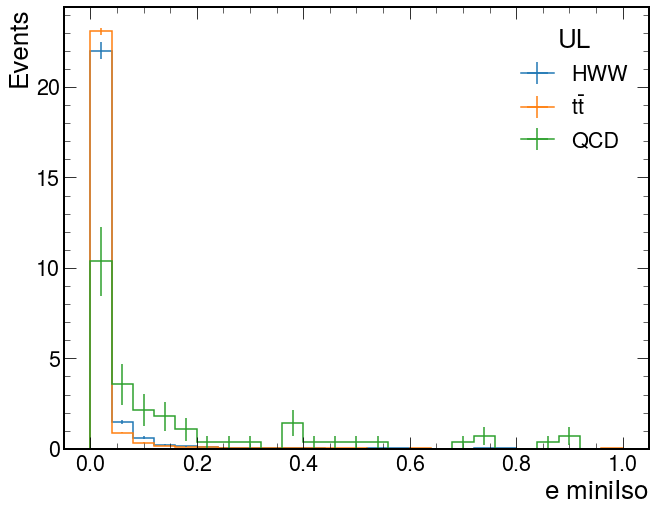

In [23]:
# electron mini isolation
fig, ax = plt.subplots(
    figsize=(9,7), 
    constrained_layout=True
)

hlep[{'leprelIso':sum, "lep_pt":sum, "region":"hadel_signal"}].plot1d(
    ax=ax,
    label="HWW",
    density=True,
)
htt[{'leprelIso':sum, "lep_pt":sum, "region":"hadel_signal"}].plot1d(
    ax=ax,
    label=r"$t \bar{t}$",
    density=True,
)
hqcd[{'leprelIso':sum, "lep_pt":sum, "region":"hadel_signal"}].plot1d(
    ax=ax,
    label="QCD",
    density=True,
)
ax.legend(
    title="UL",
)
ax.set(
    xlabel="$e$ miniIso",
    ylabel="Events"
)
fig.savefig("hww_el_miniIso.png")

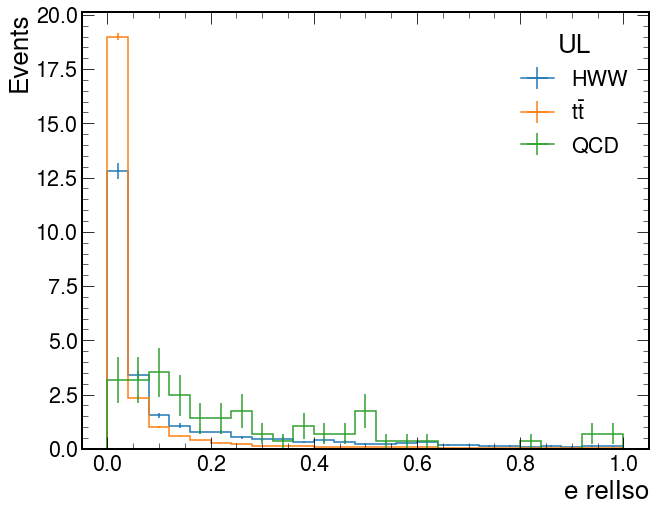

In [24]:
# electron relative isolation
fig, ax = plt.subplots(
        figsize=(9,7), 
        constrained_layout=True
    )

hlep[{'lepminiIso':sum, "lep_pt":sum, "region":"hadel_signal"}].plot1d(
    ax=ax,
    label="HWW",
    density=True,
)
htt[{'lepminiIso':sum, "lep_pt":sum, "region":"hadel_signal"}].plot1d(
    ax=ax,
    label=r"$t \bar{t}$",
    density=True,
)
hqcd[{'lepminiIso':sum, "lep_pt":sum, "region":"hadel_signal"}].plot1d(
    ax=ax,
    label="QCD",
    density=True,
)
ax.legend(
    title="UL",
)
ax.set(
    xlabel="e relIso",
    ylabel="Events"
)
fig.savefig("hww_el_relIso.png")

Let's make the same lepton isolation plots for preUL data

In [25]:
fileset = {
    'HWW': ["root://xcache/" + file for file in np.loadtxt("data/HWWdataNoUL.txt", dtype=str)]
}

hwwoutnoul = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=HwwSignalProcessor(jet_arbitration="met"),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
        maxchunks=30,
    )

In [26]:
fileset = {
    "tt": ["root://xcache/" + file for file in np.loadtxt("data/ttsemileptonicNoUl.txt", dtype=str)]
}

ttoutnoul = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=BackgroundProcessor(jet_arbitration="met"),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
    maxchunks=30,
)

In [27]:
fileset = {
    "qcd": ["root://xcache/" + file for file in np.loadtxt("data/qcd300500NoUl.txt", dtype=str)][:12] +
    ["root://xcache/" + file for file in np.loadtxt("data/qcd500700NoUl.txt", dtype=str)][:12] +
    ["root://xcache/" + file for file in np.loadtxt("data/qcd7001000NoUl.txt", dtype=str)][:12] +
    ["root://xcache/" + file for file in np.loadtxt("data/qcd10001500NoUl.txt", dtype=str)][:12] +
    ["root://xcache/" + file for file in np.loadtxt("data/qcd15002000NoUl.txt", dtype=str)][:12] +
    ["root://xcache/" + file for file in np.loadtxt("data/qcd2000infNoUl.txt", dtype=str)]
}

qcdoutnoul = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=BackgroundProcessor(jet_arbitration="met"),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
    maxchunks=30,
)

In [29]:
hlepnoul = hwwoutnoul["HWW"]["lep_kin"]
httnoul = ttoutnoul["tt"]["lep_kin"]
hqcdnoul = qcdoutnoul["qcd"]["lep_kin"]

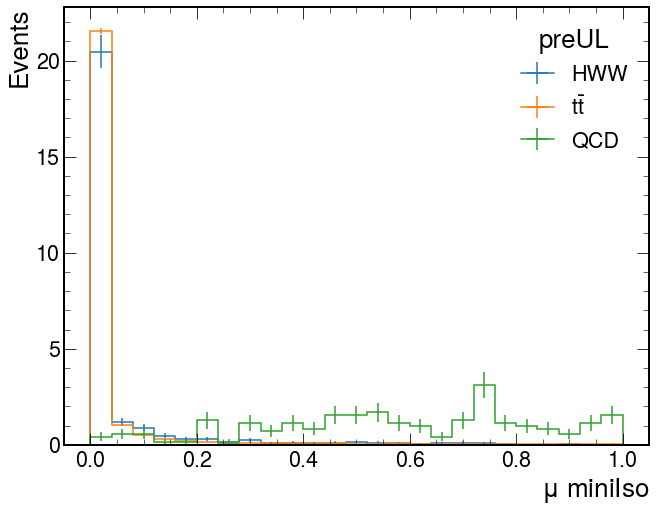

In [30]:
# muon mini isolation
fig, ax = plt.subplots(
    figsize=(9,7), 
    constrained_layout=True
)

hlepnoul[{'leprelIso':sum, "lep_pt":sum, "region":"hadmu_signal"}].plot1d(
    ax=ax,
    label="HWW",
    density=True,
)
httnoul[{'leprelIso':sum, "lep_pt":sum, "region":"hadmu_signal"}].plot1d(
    ax=ax,
    label=r"$t \bar{t}$",
    density=True,
)
hqcdnoul[{'leprelIso':sum, "lep_pt":sum, "region":"hadmu_signal"}].plot1d(
    ax=ax,
    label="QCD",
    density=True,
)
ax.legend(
    title="preUL",
)
ax.set(
    xlabel="$\mu$ miniIso",
    ylabel="Events"
)
fig.savefig("hww_mu_miniIso_preUL.png")

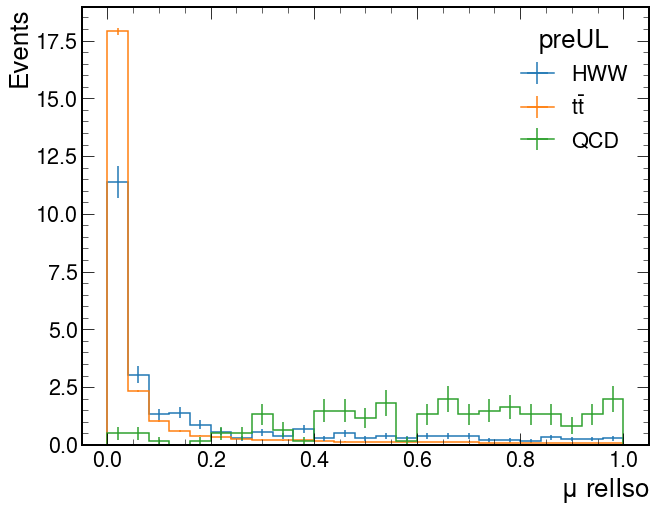

In [31]:
# muon relative isolation
fig, ax = plt.subplots(
        figsize=(9,7), 
        constrained_layout=True
    )

hlepnoul[{'lepminiIso':sum, "lep_pt":sum, "region":"hadmu_signal"}].plot1d(
    ax=ax,
    label="HWW",
    density=True,
)
httnoul[{'lepminiIso':sum, "lep_pt":sum, "region":"hadmu_signal"}].plot1d(
    ax=ax,
    label=r"$t \bar{t}$",
    density=True,
)
hqcdnoul[{'lepminiIso':sum, "lep_pt":sum, "region":"hadmu_signal"}].plot1d(
    ax=ax,
    label="QCD",
    density=True,
)
ax.legend(
    title="preUL",
)
ax.set(
    xlabel="$\mu$ relIso",
    ylabel="Events"
)
fig.savefig("hww_mu_relIso_preUL.png")

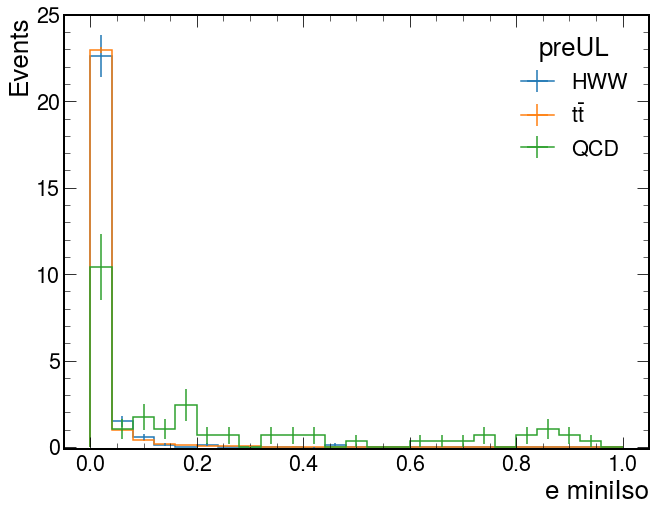

In [32]:
# electron mini isolation
fig, ax = plt.subplots(
    figsize=(9,7), 
    constrained_layout=True
)

hlepnoul[{'leprelIso':sum, "lep_pt":sum, "region":"hadel_signal"}].plot1d(
    ax=ax,
    label="HWW",
    density=True,
)
httnoul[{'leprelIso':sum, "lep_pt":sum, "region":"hadel_signal"}].plot1d(
    ax=ax,
    label=r"$t \bar{t}$",
    density=True,
)
hqcdnoul[{'leprelIso':sum, "lep_pt":sum, "region":"hadel_signal"}].plot1d(
    ax=ax,
    label="QCD",
    density=True,
)
ax.legend(
    title="preUL",
)
ax.set(
    xlabel="e miniIso",
    ylabel="Events",
    ylim=(-0.1, 25)
)
fig.savefig("hww_el_miniIso_preUL.png")

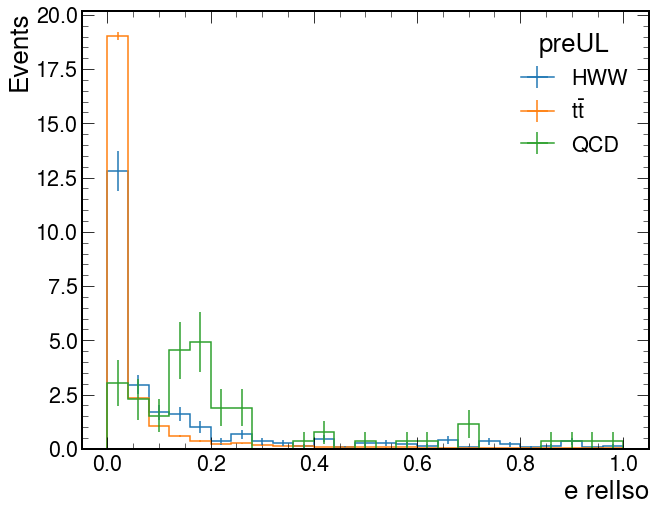

In [33]:
# electron relative isolation
fig, ax = plt.subplots(
    figsize=(9,7), 
    constrained_layout=True
)

hlepnoul[{'lepminiIso':sum, "lep_pt":sum, "region":"hadel_signal"}].plot1d(
    ax=ax,
    label="HWW",
    density=True,
)
httnoul[{'lepminiIso':sum, "lep_pt":sum, "region":"hadel_signal"}].plot1d(
    ax=ax,
    label=r"$t \bar{t}$",
    density=True,
)
hqcdnoul[{'lepminiIso':sum, "lep_pt":sum, "region":"hadel_signal"}].plot1d(
    ax=ax,
    label="QCD",
    density=True,
)
ax.legend(
    title="preUL",
)
ax.set(
    xlabel="e relIso",
    ylabel="Events"
);
fig.savefig("hww_el_relIso_preUL.png")

Now, we want to find the best working points for the lepton isolation variables and compare the results using the UL and preUL data. For this purpose we use a ROC curve

In [179]:
def effcut(hist, direction=1):
    """
    returns efficiency for a series of cuts
    given some histogram (Hist object)

    direction: int (1 or -1)
        direction to apply the cut
    """
    vals = hist.values()
    eff_cut = np.cumsum(vals[::direction])
    eff_cut = eff_cut[::direction] / eff_cut[-1]
    return eff_cut


def roc(sig_hist, bkg_hist, direction=1):
    """
    return signal and background efficiencies
    """
    x = sig_hist.axes.centers[0]
    y = np.c_[effcut(sig_hist, direction), effcut(bkg_hist, direction)]
    interp = scipy.interpolate.interp1d(x, y, axis=0)
    sig_eff = interp(x)[:,0]
    bkg_eff = interp(x)[:,1]
    return sig_eff, bkg_eff


def plot_roc(sigUL, bkgUL, sigpreUL, bkgpreUL, title=None, direction=1):
    """
    plot a roc curve (bkg eff vs sig eff) for UL and preUL data
    """
    plt.rcParams["legend.title_fontsize"] = "x-small"
    
    fig, ax = plt.subplots(
        figsize=(10,7),
        constrained_layout=True,
    )
    # rocs
    ax.plot(*roc(sigUL, bkgUL))
    ax.plot(*roc(sigpreUL, bkgpreUL))
    
    # working points
    l1, = ax.plot(
        [*roc(sigUL, bkgUL)][0][2], 
        [*roc(sigUL, bkgUL)][1][2], 
        "og", 
        label="0.12"
    )
    ax.plot(
        [*roc(sigpreUL, bkgpreUL)][0][2], 
        [*roc(sigpreUL, bkgpreUL)][1][2], 
        "og"
    )
    l2, = ax.plot(
        [*roc(sigUL, bkgUL)][0][5], 
        [*roc(sigUL, bkgUL)][1][5], 
        "or", 
        label="0.2"
    )
    ax.plot(
        [*roc(sigpreUL, bkgpreUL)][0][5], 
        [*roc(sigpreUL, bkgpreUL)][1][5], 
        "or"
    )
    l3, = ax.plot(
        [*roc(sigUL, bkgUL)][0][7],
        [*roc(sigUL, bkgUL)][1][7], 
        "ok", 
        label="0.32"
    )
    ax.plot(
        [*roc(sigpreUL, bkgpreUL)][0][7], 
        [*roc(sigpreUL, bkgpreUL)][1][7], 
        "ok"
    )
    
    ax.set(
        title=rf"{title}",
        xlabel="signal efficiency",
        ylabel="background efficiency"
    )
    
    legend = ax.legend(
        ["UL","preUL"],
        title="HWW"
    )
    
    ax.legend(
        [l1, l2, l3], 
        ["0.1","0.2","0.3"], 
        title="Working points",
        loc="upper center",
        prop={"size": 16},
    )
    ax.add_artist(legend)

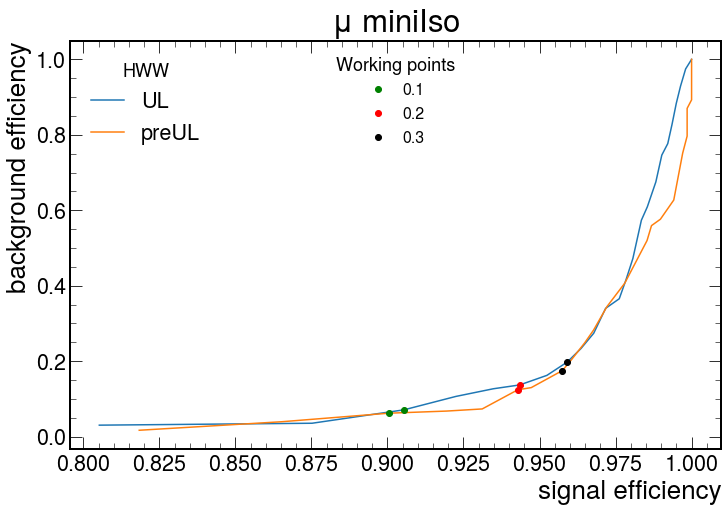

In [180]:
mumini_sigUL = hlep[{'leprelIso':sum, "lep_pt":sum, "region":"hadmu_signal"}]
mumini_bkgUL = hqcd[{'leprelIso':sum, "lep_pt":sum, "region":"hadmu_signal"}]

mumini_sigNUL = hlepnoul[{'leprelIso':sum, "lep_pt":sum, "region":"hadmu_signal"}]
mumini_bkgNUL = hqcdnoul[{'leprelIso':sum, "lep_pt":sum, "region":"hadmu_signal"}]

plot_roc(
    mumini_sigUL, 
    mumini_bkgUL,
    mumini_sigNUL,
    mumini_bkgNUL, 
    title="$\mu$ miniIso"
)
plt.gcf().savefig("hww_roc_mumini.png")

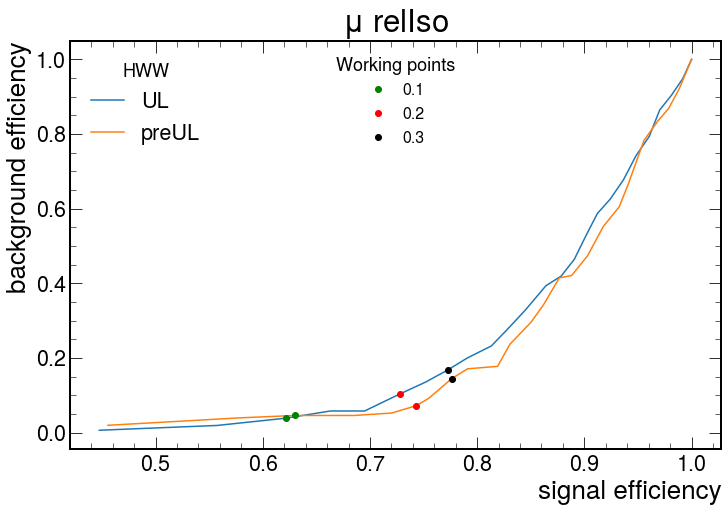

In [181]:
# mu relIso
murel_sigUL = hlep[{'lepminiIso':sum, "lep_pt":sum, "region":"hadmu_signal"}]
murel_bkgUL = hqcd[{'lepminiIso':sum, "lep_pt":sum, "region":"hadmu_signal"}]

murel_sigNUL = hlepnoul[{'lepminiIso':sum, "lep_pt":sum, "region":"hadmu_signal"}]
murel_bkgNUL = hqcdnoul[{'lepminiIso':sum, "lep_pt":sum, "region":"hadmu_signal"}]

plot_roc(
    murel_sigUL, 
    murel_bkgUL,
    murel_sigNUL,
    murel_bkgNUL, 
    title="$\mu$ relIso"
)
plt.gcf().savefig("hww_roc_murel.png")

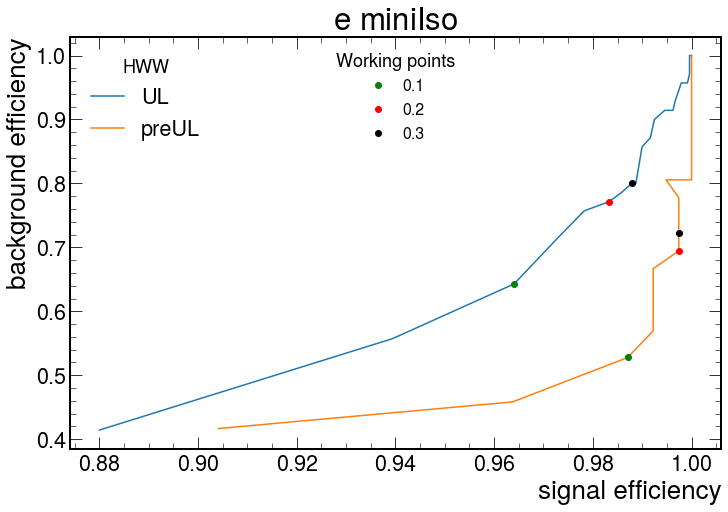

In [182]:
elmini_sigUL = hlep[{'leprelIso':sum, "lep_pt":sum, "region":"hadel_signal"}]
elmini_bkgUL = hqcd[{'leprelIso':sum, "lep_pt":sum, "region":"hadel_signal"}]

elmini_sigNUL = hlepnoul[{'leprelIso':sum, "lep_pt":sum, "region":"hadel_signal"}]
elmini_bkgNUL = hqcdnoul[{'leprelIso':sum, "lep_pt":sum, "region":"hadel_signal"}]

plot_roc(
    elmini_sigUL, 
    elmini_bkgUL,
    elmini_sigNUL,
    elmini_bkgNUL, 
    title="$e$ miniIso"
)
plt.gcf().savefig("hww_roc_elmini.png");

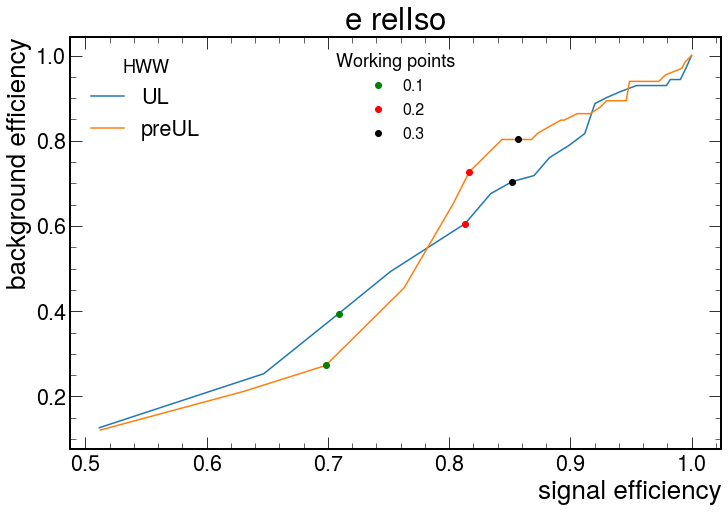

In [183]:
erel_sigUL = hlep[{'lepminiIso':sum, "lep_pt":sum, "region":"hadel_signal"}]
erel_bkgUL = hqcd[{'lepminiIso':sum, "lep_pt":sum, "region":"hadel_signal"}]

erel_sigNUL = hlepnoul[{'lepminiIso':sum, "lep_pt":sum, "region":"hadel_signal"}]
erel_bkgNUL = hqcdnoul[{'lepminiIso':sum, "lep_pt":sum, "region":"hadel_signal"}]

plot_roc(
    erel_sigUL, 
    erel_bkgUL,
    erel_sigNUL,
    erel_bkgNUL, 
    title="$e$ relIso"
)
plt.gcf().savefig("hww_roc_elrel.png")